In [ ]:
! pip install pycm livelossplot
! pip install radiant_mlhub
%pylab inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from radiant_mlhub import Dataset
import tarfile
import json
import matplotlib.image as mpimg
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
from livelossplot import PlotLosses

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Data Preprocessing

In [ ]:
download_dir = Path('/content/gdrive/MyDrive/Surprise_Storm').expanduser().resolve()

In [ ]:
train_data = []

train_source = 'nasa_tropical_storm_competition_train_source'
train_labels = 'nasa_tropical_storm_competition_train_labels'

jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)


    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    with open(labels_path) as src:
        labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
        int(labels_data['wind_speed'])
    ])

train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean', 'Wind Speed']
).sort_values(by=['Image ID']).reset_index(drop=True)

train_df.head()

In [ ]:
test_data = []

test_source = 'nasa_tropical_storm_competition_test_source'

jpg_names = glob(str(download_dir / test_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)

    test_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
    ])

test_df = pd.DataFrame(
    np.array(test_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean']
).sort_values(by=['Image ID']).reset_index(drop=True)

test_df.head()

In [ ]:
df_count = train_df.groupby(['Storm ID']).size().reset_index(name='count').sort_values(['count'], ascending=False)
train_df_count = pd.merge(df_count, test_df, on=['Storm ID'], how='left', indicator='Exist')
train_df_count['Exist'] = np.where(train_df_count.Exist == 'both', True, False)
train_df_count.loc[train_df_count['Exist'] == True].drop_duplicates(['Storm ID'])

In [ ]:
df_count.loc[df_count['count'] > 100].head(10)

,Storm ID,count
108,fcr,648
439,xjo,617
471,ywf,614
290,psz,576
184,ing,527
185,ipa,527
135,gic,496
93,eoi,488
116,fna,477
427,wsy,477


In [ ]:
! cp -r /content/gdrive/MyDrive/Storm/nasa_tropical_storm_competition_train_source/nasa_tropical_storm_competition_train_source_fcr_* ./drive/MyDrive/Storm

## Convolutional LSTM

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
                 kernel_size, padding, activation, image_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *image_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *image_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *image_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [ ]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
                 kernel_size, padding, activation, image_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
                                  kernel_size, padding, activation, image_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
                             height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
                        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
                        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
                 activation, image_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, image_size=image_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, image_size=image_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return nn.Sigmoid()(output)

## Model training with fcr

In [ ]:
def train_conv_lstm(model, optimizer, criterion, train_loader):

  train_loss = 0                                                 
  model.train()  

  for batch_num, (input, target) in enumerate(train_loader, 1): 

    input, target = input.to(device), target.to(device)
    output = model(input)     

    loss = criterion(output.flatten(), target.flatten())       
    loss.backward()                     

    optim.step()                                               
    optim.zero_grad()                                           
    train_loss += loss.item() * input.size(0)   

  train_loss /= len(train_loader.dataset)  

  return train_loss           


def validate_conv_lstm(model, val_loader):

  val_loss = 0                                                 
  model.eval()        

  with torch.no_grad():                                          
      for input, target in val_loader:  
          input, target = input.to(device), target.to(device)                        
          output = model(input)  

          loss = criterion(output.flatten(), target.flatten())   
          val_loss += loss.item() * input.size(0)    

  val_loss /= len(val_loader.dataset) 
  
  return val_loss


def eval_images(model, val_loader, val_num=5):
  """
  Function generating one predicted images and compare with the real one
  """

  model.eval()    

  with torch.no_grad():   
    fig, ax = plt.subplots(2, val_num, figsize=(20, 8))

    for i in range(val_num):
      input, target = next(iter(val_loader))
      input, target = input.to(device), target.to(device)
      output = model(input)
      ax[0, i].imshow(transforms.ToPILImage()(output[0]))
      ax[1, i].imshow(transforms.ToPILImage()(target[0]))

In [ ]:
# Best hyperparameters after a series of tuning work

lr = 1e-4
kernal_size = (3, 3)
num_kernals = 20
activation = "relu"
num_layers = 3
padding = (1,1)
num_epochs = 30
batch_size = 2
sequence_len = 5

## Create customized dataset

In [ ]:
class StormTensorDataset(TensorDataset):
    def __init__(self, data, transform=None, sequence_len=sequence_len):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            transform (callable, optional): Optional transform to be applied
                on a sample.
            sequence_len: 
        """
        self.data = data
        self.transform = transform
        self.sequence_len = sequence_len

    def __len__(self):
        return len(self.data) - self.sequence_len

    def __getitem__(self, idx):
        if self.transform:
            sample = torch.stack([self.transform(self.data[idx+i]) for i in range(self.sequence_len)])
            sample = torch.transpose(sample, 0, 1)
            target = self.transform(self.data[idx+self.sequence_len])
        return sample, target

In [ ]:
jpg_fcr = sorted(glob('./drive/MyDrive/Storm/**/*.jpg'))

train_img = jpg_fcr[:int(len(jpg_fcr) * 0.8)]
val_img = jpg_fcr[int(len(jpg_fcr) * 0.8):]

train_img = [Image.open(train_img[i]) for i in range(len(train_img))]
val_img = [Image.open(val_img[i]) for i in range(len(val_img))]

transform = transforms.Compose([transforms.ToTensor()])  # transforms.Normalize(0.2408, 0.2030)
train_data = StormTensorDataset(train_img, transform)
val_data = StormTensorDataset(val_img, transform)

train_loader = DataLoader(train_data, batch_size=6, shuffle=False)
val_loader = DataLoader(val_data, batch_size=6, shuffle=False)

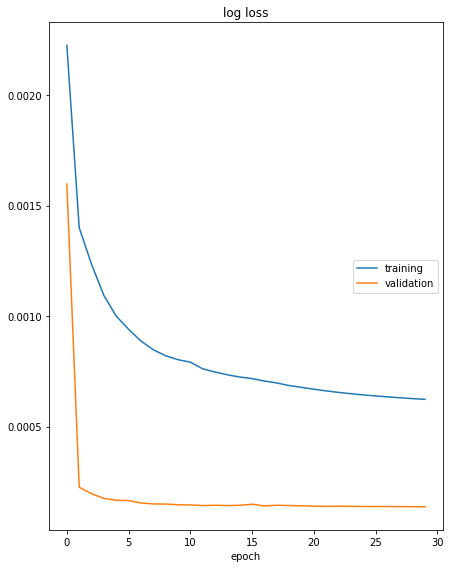

log loss
	training         	 (min:    0.001, max:    0.002, cur:    0.001)
	validation       	 (min:    0.000, max:    0.002, cur:    0.000)
Epoch:30 Training Loss:0.0006235771 Validation Loss:0.0001378247



In [ ]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=num_kernals, 
                kernel_size=kernal_size, padding=padding, activation=activation, 
                image_size=(366, 366), num_layers=num_layers).to(device)

optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

liveloss = PlotLosses()
for epoch in range(1, num_epochs+1):
  logs = {}

  train_loss = train_conv_lstm(model, optim, criterion, train_loader)
  val_loss = validate_conv_lstm(model, val_loader)

  logs['' + 'log loss'] = train_loss
  logs['val_' + 'log loss'] = val_loss
  liveloss.update(logs)
  liveloss.draw()

  print("Epoch:{} Training Loss:{:.10f} Validation Loss:{:.10f}\n".format(
        epoch, train_loss, val_loss))

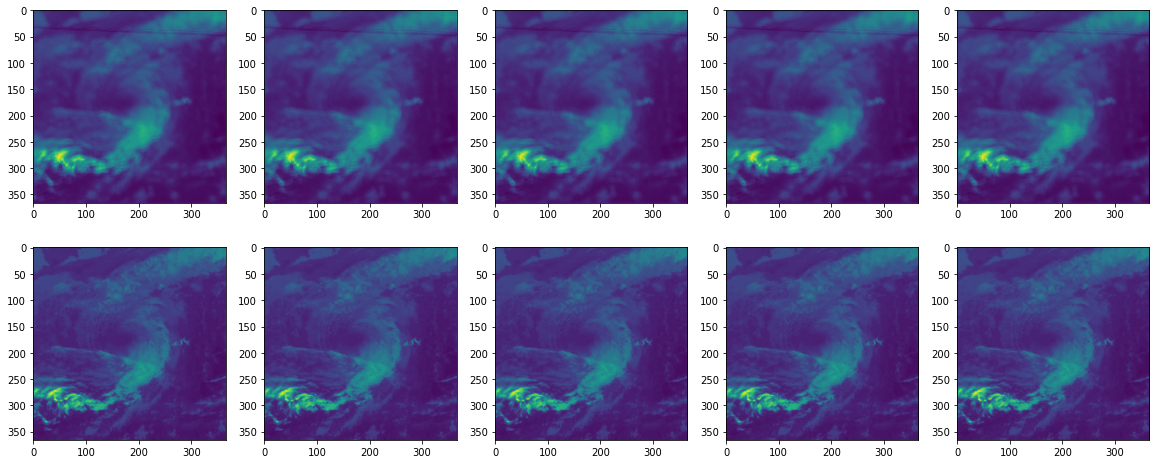

In [ ]:
eval_images(model, val_loader)

In [ ]:
# Save model

! mkdir ./drive/MyDrive/models
model_save_name = 'fcr_convLSTM_model_1.pt'
path = F"/content/drive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)

## Train our model for SURPRISE storm and predict 5 consective images

In [ ]:
# Best hyperparameters for the surprise storm

lr = 2e-4
kernal_size = (3, 3)
num_kernals = 30
activation = "relu"
num_layers = 2
padding = (1,1)
num_epochs = 500
batch_size = 10
sequence_len = 4

In [ ]:
# get locations for all of the images
jpg_fcr = sorted(glob('./drive/MyDrive/Surprise_Storm/**source**/**/*.jpg'))[:95]

train_img = [Image.open(jpg_fcr[i]) for i in range(len(jpg_fcr))]

# Create dataset and dataloader for surprise storm
train_data = StormTensorDataset(train_img, transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [ ]:
def predict_images(model, image_locs, next_image=5):

  model.eval()

  for i in range(next_image):
    x = [Image.open(image_loc) for image_loc in image_locs[len(image_locs)-5:]]

    transform = transforms.Compose([transforms.ToTensor()])
    x = torch.stack([transform(i) for i in x])
    x = torch.transpose(x, 0, 1).unsqueeze(0).to(device)
    
    img_new = transforms.ToPILImage()(model(x)[0])

    img_new_loc = f"/content/{i+1}.jpg"
    img_new.save(img_new_loc)
    image_locs.append(img_new_loc)


predict_images(model, jpg_fcr, 5)

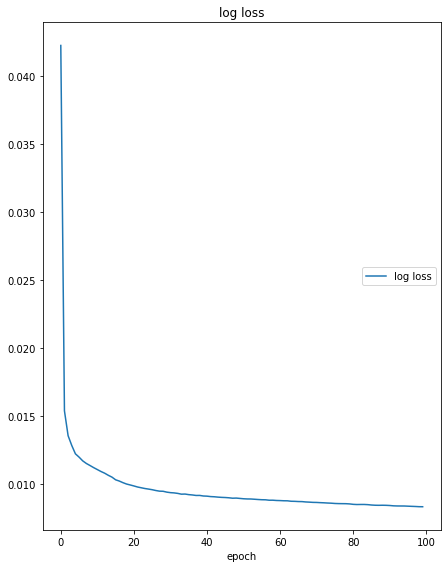

log loss
	log loss         	 (min:    0.008, max:    0.042, cur:    0.008)
Epoch:100 Training Loss:0.0083250874



In [ ]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=num_kernals, 
                kernel_size=kernal_size, padding=padding, activation=activation, 
                image_size=(366, 366), num_layers=num_layers).to(device)

optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

liveloss = PlotLosses()
for epoch in range(1, num_epochs+1):
  logs = {}

  train_loss = train_conv_lstm(model, optim, criterion, train_loader)
  # val_loss = validate_conv_lstm(model, val_loader)

  logs['' + 'log loss'] = train_loss
  # logs['val_' + 'log loss'] = val_loss
  liveloss.update(logs)
  liveloss.draw()

  # print("Epoch:{} Training Loss:{:.10f} Validation Loss:{:.10f}\n".format(
  #       epoch, train_loss, val_loss))
  print("Epoch:{} Training Loss:{:.10f}\n".format(epoch, train_loss))

In [ ]:
model_save_name = 'surprise_convLSTM_model_1.pt'
path = F"/content/drive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)

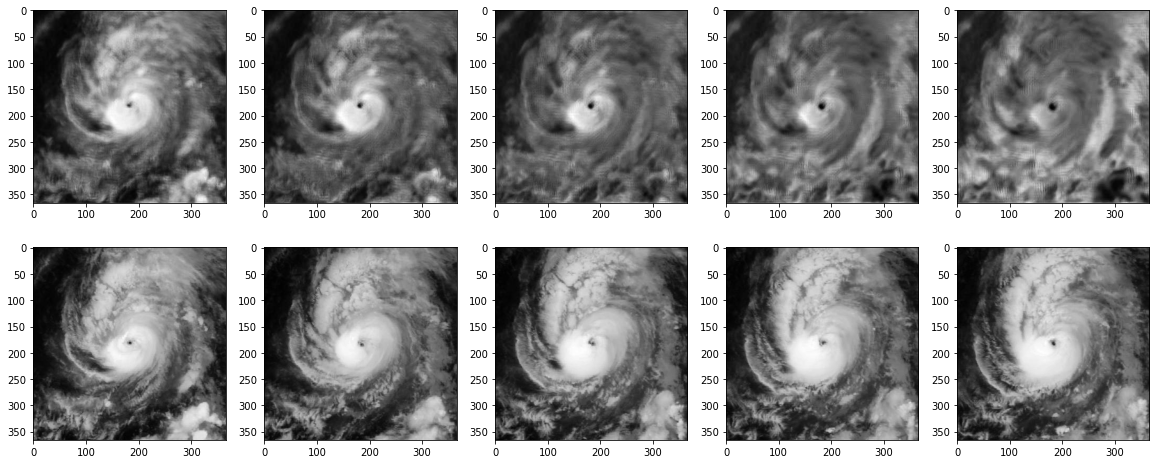

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for i in range(4):
  ax[0,i].imshow(Image.open(f'{i+1}.jpg'), cmap='gray')
  ax[1,i].imshow(Image.open(f'./drive/MyDrive/Surprise_Storm/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical_storm_competition_surprise_storm_source_sss_0{96+i}/image.jpg'), cmap='gray')

ax[0,4].imshow(Image.open('5.jpg'), cmap='gray')
ax[1,4].imshow(Image.open(f'./drive/MyDrive/Surprise_Storm/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical_storm_competition_surprise_storm_source_sss_100/image.jpg'), cmap='gray')

In [27]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from pathlib import Path
from PIL import Image
import numpy as np

def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def metric(target, num, need_zero):
  # Load target and predicted images for comparison
  if need_zero:
    target_path = Path(f'./drive/MyDrive/Surprise_Storm/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical_storm_competition_surprise_storm_source_sss_0{target}/image.jpg')
  if not need_zero:
    target_path = Path(f'./drive/MyDrive/Surprise_Storm/nasa_tropical_storm_competition_surprise_storm_source/nasa_tropical_storm_competition_surprise_storm_source_sss_{target}/image.jpg')
  predic_path = Path(f'./{num}.jpg')

  # Load images and cast to np arrays, defining datatypes as floats for scale2range function
  target, predic = np.array(Image.open(target_path), dtype=np.float32), np.array(Image.open(predic_path), dtype=np.float32)

  # Scale predicted image to target range
  predic = scale2range(predic, [target.min(), target.max()])

  # Cast to uint8 to accommodate for consistent SSIM and MSE results
  target, predic = target.astype(np.uint8), predic.astype(np.uint8)

  # Compute metrics
  s, m = ssim(target, predic), mse(target, predic)
  print("SSIM:", s, "MSE: ", m)

In [ ]:
metric(96, 1, True)
metric(97, 2, True)
metric(98, 3, True)
metric(99, 4, True)
metric(100, 5, False)

Prediction 1 SSIM: 0.5229748126842569 MSE:  479.9063199856669
Prediction 2 SSIM: 0.3523207460779303 MSE:  1670.4326495267103
Prediction 3 SSIM: 0.32898105818704804 MSE:  2551.339178536236
Prediction 4 SSIM: 0.29887770896074334 MSE:  3377.6992370629164
Prediction 5 SSIM: 0.2644819644155947 MSE:  4581.3040998536835
